In [2]:
##############################################################################
# Description: Baysian Neural Network using Numpyro for predicting transistor frequency data (Jan Henningers data). 
# Author: Tobias Leitgeb
##############################################################################

import numpyro
numpyro.set_platform("cpu")

from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO
import numpyro.distributions as dist
import jax
import jax.numpy as jnp
import jax.random as jr
from typing import Tuple, Callable, List
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns
import numpy as np


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 39.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 35.4 MB/s eta 0:00:00


In [3]:
def get_data(
        X: jax.Array,
        Y: jax.Array,
        f: jax.Array,
        *,
        split: Tuple[float, float, float] = (0.8, 0.1),
        dense: bool = False,
        key: jax.random.PRNGKey,
):
    #split data into training testing and validation
    n = X.shape[0]
    n_train = int(n * split[0])
    n_test = int(n * split[1])
   

    #shuffle data
    key, subkey = jax.random.split(key)
    idx = jax.random.permutation(subkey, n)
    X = X[idx, :]
    Y = Y[idx, :]

    #split data
    X_train, Y_train = jnp.array(X[:n_train, :]), jnp.array(Y[:n_train, :])
    X_test, Y_test = jnp.array(X[n_train:n_train + n_test, :]), jnp.array(Y[n_train:n_train + n_test, :])
    X_val, Y_val = jnp.array(X[n_train + n_test:, :]), jnp.array(Y[n_train + n_test:, :])

    if dense:
        X_train = jnp.repeat(X_train, len(f), axis=0)
        X_train = jnp.concatenate([X_train, jnp.tile(f, len(X_train)//len(f))[:,None]], axis=1)
        X_test = jnp.repeat(X_test, len(f), axis=0)
        X_test = jnp.concatenate([X_test, jnp.tile(f, len(X_test)//len(f))[:,None]], axis=1)
        X_val = jnp.repeat(X_val, len(f), axis=0)
        X_val = jnp.concatenate([X_val, jnp.tile(f, len(X_val)//len(f))[:,None]], axis=1)
        return (X_train, Y_train), (X_test, Y_test), (X_val, Y_val)
    else:
        return (X_train, Y_train), (X_test, Y_test), (X_val, Y_val)
    

X = jnp.load("data/X_transistor.npy")
data = jnp.load("data/data_transistor_f115.npy", allow_pickle=True).item()
f, Y = data["freq"], data["envelope"]


# = (f - f.min())/(f.max() - f.min())

data_key = jr.PRNGKey(0)
(X_train, Y_train), (X_test, Y_test), (X_val, Y_val) = get_data(
                                                            X, 
                                                            Y, 
                                                            f,               
                                                            split=(0.88,0.12), 
                                                            key=data_key,
                                                            dense=False
                                                        )

print("Train:", X_train.shape, Y_train.shape,"Test:", X_test.shape, Y_test.shape, "Val:", X_val.shape, Y_val.shape)

#Y_train = Y_train[:, 70:100]
#Y_test = Y_test[:, 70:100]

Train: (96, 4) (96, 115) Test: (13, 4) (13, 115) Val: (1, 4) (1, 115)


In [4]:
def dense_layer(
        i: int,
        size: List[int],
):
    W = numpyro.sample(f"W{i}", dist.Normal(0, 1).expand(size))
    b = numpyro.sample(f"b{i}", dist.Normal(0, 1).expand((size[-1],)))
    return W, b

def wideband_dnn(
        X: jax.Array,
        Y: jax.Array,
        layers: List[int],
):
    N, input_dim = X.shape
    activation = jax.nn.relu
    #create layers
    W = []
    b = []
    for i, layer in enumerate(layers):
        W_, b_ = dense_layer(i, [input_dim, layer])
        W.append(W_)
        b.append(b_)
        input_dim = layer

    #input layer
    z = activation(jnp.dot(X, W[0]) + b[0])

    #hidden layers
    for i in range(1, len(W) - 1):
        z = activation(jnp.dot(z, W[i]) + b[i])

    #output layer with no activation
    z = jnp.dot(z, W[-1]) + b[-1]
    z = z.squeeze()
    if Y is not None:
        assert Y.shape == z.shape , f"Y shape {Y.shape} does not match z shape {z.shape}"

    precision_obs = numpyro.sample("precision_obs", dist.Gamma(3., 1.))
    sigma_obs = 1.0 / jnp.sqrt(precision_obs)

    with numpyro.plate("data", N):
        numpyro.sample(
            "Y", 
            dist.Normal(z, sigma_obs).to_event(1), 
            obs=Y
        )

LAYERS = [100, 100, Y.shape[-1]]

try:
    render = numpyro.render_model(wideband_dnn, (X_train, Y_train, LAYERS))
except:
    render = None
    print("Module not installed. (pip install graphviz), (sudo apt-get install graphviz)")



Module not installed. (pip install graphviz), (sudo apt-get install graphviz)


In [5]:
#inference with svi
from numpyro.infer.autoguide import AutoDiagonalNormal, AutoLaplaceApproximation, AutoMultivariateNormal, AutoIAFNormal, AutoLowRankMultivariateNormal, AutoDelta
from numpyro.infer import SVI, Trace_ELBO, Predictive

guide = AutoDiagonalNormal(wideband_dnn)
svi = SVI(wideband_dnn, guide, numpyro.optim.Adam(0.05), Trace_ELBO())

svi_result = svi.run(
    jax.random.PRNGKey(0),
    num_steps=10000,
    X=X_train,
    Y=Y_train,
    layers=LAYERS
)

100%|██████████| 10000/10000 [00:20<00:00, 481.92it/s, init loss: 23217530.0000, avg. loss [9501-10000]: 28807.0332]


In [6]:
samples = guide.sample_posterior(jax.random.PRNGKey(1), svi_result.params, sample_shape=(500,))
predictive = Predictive(wideband_dnn, samples, return_sites=["Y"])
predictions = predictive(jax.random.PRNGKey(2), X_test, None, LAYERS)
print(predictions["Y"].shape)

mean = jnp.mean(predictions["Y"], axis=0)
var = jnp.var(predictions["Y"], axis=0)

(500, 13, 115)


In [7]:
def plot_testset(
            frequency: jax.Array, 
            test_y: jax.Array, 
            prediction: jax.Array, 
            var_pred: jax.Array=None, 
            grid: tuple = (4,4),
            figsize: tuple = (15, 15)
        )-> plt.figure:
        """
        Plots the test set predictions and true values.

        Args:
            frequency (ndarray): The frequency values.
            test_y (ndarray): The true output values of shape (n_test, p).
            prediction (ndarray): The predicted output values of shape (n_test, p).
            grid (tuple): The grid size for subplots.
        """
        fig, ax  = plt.subplots(grid[0], grid[1], figsize=figsize)
        
        if grid[0] == 1 and grid[1] == 1:
            ax = [ax]

        ax = ax.flatten()

        for i in range(grid[0]*grid[1]):
            ax[i].plot(frequency, test_y[i, :], color='black')
            ax[i].plot(frequency, prediction[i, :], color='blue')
            if var_pred is not None:
                pred_std = np.sqrt(var_pred[i, :])
                ax[i].fill_between(
                    frequency, 
                    prediction[i, :] - 2*pred_std, 
                    prediction[i, :] + 2*pred_std, 
                    color='blue', alpha=0.2
                )
        
            ax[i].set_ylabel('dB')
            ax[i].legend(['True', 'Predicted'])
            ax[i].grid()
            ax[i].set_xscale('log')

            error = minmaxrmspe(test_y[i, :][None,:], prediction[i, :][None,:])
            ax[i].set_title('minmaxRMSE: {:.2f}%'.format(error))
            #add axis only for the last row
            if i >= grid[0]*(grid[1]-1):
                ax[i].set_xlabel('Frequency (Hz)')
            plt.tight_layout()
            pass

def minmaxrmspe(
            test_y: jax.Array, 
            prediction: jax.Array
        )-> float:
        """
        Calculates the Root Mean Square Percentage Error.

        Args:
            test_y (ndarray): The true output values of shape (n, p).
            prediction (ndarray): The predicted output values of shape (n, p).

        Returns:
            float: The Root Mean Square Percentage Error.
        """
        p = test_y.shape[1]
        error = np.mean(
            np.sqrt(1 / p * np.sum((test_y - prediction) ** 2, axis=1))
            * 100 / (np.max(test_y, axis=1) - np.min(test_y, axis=1))
        )
        return error

minmaxrmspe: 2.5482337


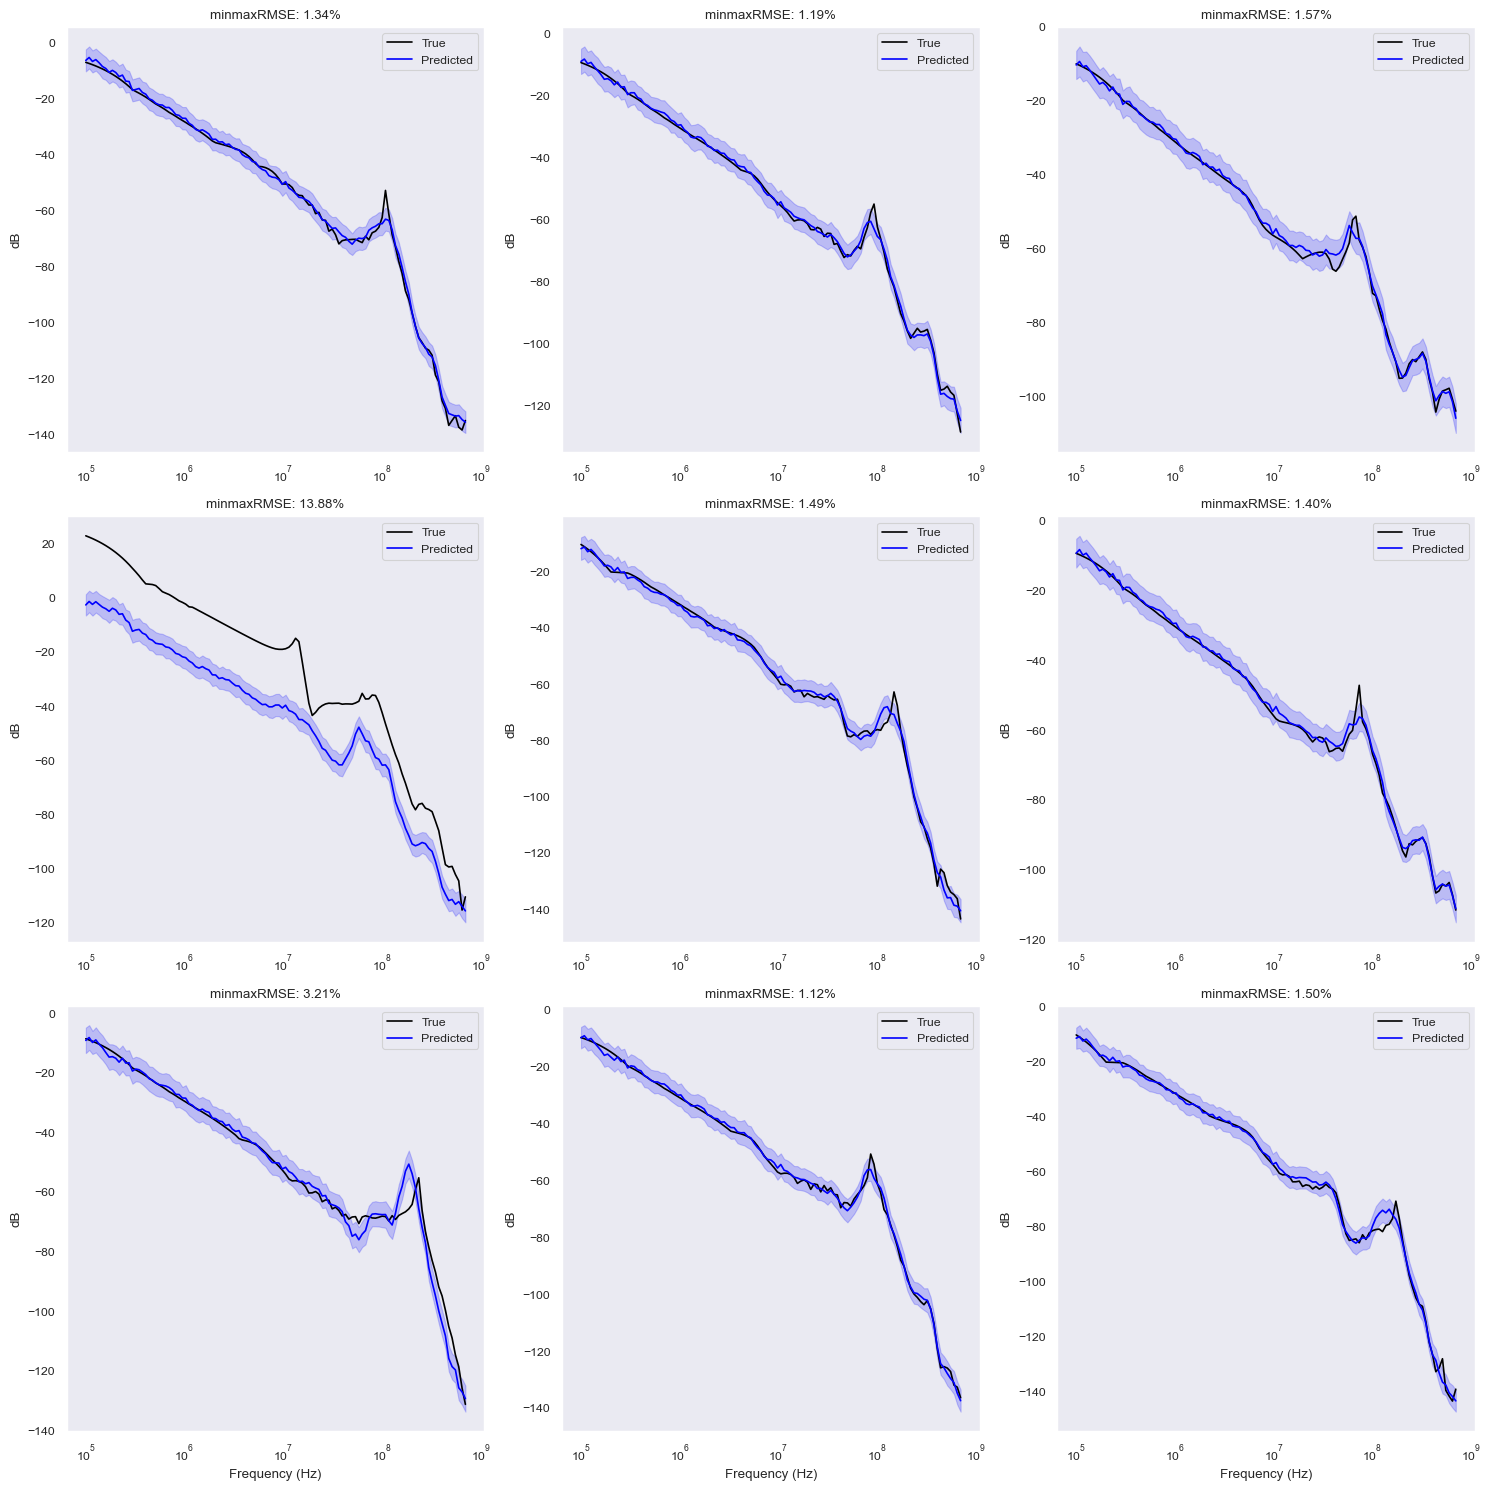

In [8]:
sns.set_theme("paper")
print("minmaxrmspe:", minmaxrmspe(Y_test, mean))
plot_testset(f, Y_test, mean, var, grid=(3,3), figsize=(15,15))